<a href="https://colab.research.google.com/github/ernstmargo/anomaly-detection/blob/main/ARIMA_based_method.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data preprosessing

## Import, install, readd csv 

In [ ]:
 pip install pmdarima

     |████████████████████████████████| 1.4 MB 5.1 MB/s 
     |████████████████████████████████| 9.8 MB 56.9 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
import pandas as pd
from pandas import DataFrame
import numpy as np
import ipaddress 
import matplotlib.pyplot as plt
from datetime import datetime
from scipy import stats

import statsmodels as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import statistics

from matplotlib import pyplot


In [ ]:
df=pd.read_csv('/content/drive/MyDrive/Dataset/Wednesday-workingHours.pcap_ISCX.csv')
#df=pd.read_csv('/content/drive/MyDrive/Dataset/full_dataset')

In [ ]:
def format_name(columns):
  col= []
  for x in columns:
        x=x.strip().lower().replace(' ', '_').replace('/', '_').replace('.', '_')
        col.append(x)
  return col

In [ ]:
df.columns=format_name(df.columns)

## Dataframe to time series

In [ ]:
time_series=df[['timestamp', 'total_fwd_packets']]

In [ ]:
time_series['timestamp'] = pd.to_datetime(time_series['timestamp'], dayfirst=True)
time_series = time_series.set_index('timestamp') 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
time_series_min=time_series.groupby(pd.Grouper(freq='1min')).sum()

In [ ]:
def rename_lables(df):
    df=df.replace({'label': {'DoS slowloris':'DOS','DoS Slowhttptest':'DOS', 'DoS Hulk':'DOS', 'DoS GoldenEye':'DOS', 'Heartbleed':'DOS', 'DDOS':'DOS'}})
    df.loc[ df['label'] !='DOS', 'label'] = 'BENIGN'
    df=df.replace({'label': {'BENIGN':0, 'DOS':1}})
    return df

In [ ]:
time_series_ips=df[['timestamp', 'source_ip']]
time_series_ips['timestamp'] = pd.to_datetime(time_series_ips['timestamp'],dayfirst=True)
time_series_ips = time_series_ips.set_index('timestamp') 
time_series_ips=time_series_ips.groupby(pd.Grouper(freq='1min')).count()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## BoxCox Transformations

In [ ]:
time_series_min_box_cox=time_series_min
for_box_cox=list(np.asarray(time_series_min_box_cox['total_fwd_packets']) + 1)
time_series_min_box_cox['total_fwd_packets'], fitted_lambda = stats.boxcox(for_box_cox)


In [ ]:
time_series_min=time_series.groupby(pd.Grouper(freq='1min')).sum()
time_series_min

,total_fwd_packets
timestamp,
2017-07-05 01:00:00,2345
2017-07-05 01:01:00,904
2017-07-05 01:02:00,597
2017-07-05 01:03:00,1285
2017-07-05 01:04:00,1310
...,...
2017-07-05 12:55:00,977
2017-07-05 12:56:00,2625
2017-07-05 12:57:00,7719


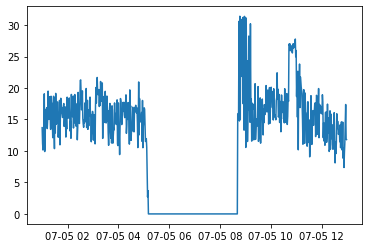

In [ ]:
pyplot.plot(time_series_min_box_cox['total_fwd_packets'])
pyplot.show()

# Find ARIMA params

In [ ]:
from statsmodels.tsa.stattools import adfuller
def ad_test(dataset):
     dftest = adfuller(dataset, autolag = 'AIC')
     print("1. ADF : ",dftest[0])
     print("2. P-Value : ", dftest[1])
     print("3. Num Of Lags : ", dftest[2])
     print("4. Num Of Observations Used For ADF Regression:",      dftest[3])
     print("5. Critical Values :")
     for key, val in dftest[4].items():
         print("\t",key, ": ", val)


In [ ]:
ad_test(time_series_min_box_cox)

1. ADF :  -2.0557763737577046
2. P-Value :  0.26266469789866675
3. Num Of Lags :  8
4. Num Of Observations Used For ADF Regression: 711
5. Critical Values :
	 1% :  -3.439580754053961
	 5% :  -2.865613606467485
	 10% :  -2.568939269723711


In [ ]:
from pmdarima import auto_arima
stepwise_fit = auto_arima(time_series_min_box_cox['total_fwd_packets'], trace=True, suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3562.719, Time=0.43 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3993.347, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3612.419, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3632.740, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3991.347, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3561.439, Time=0.29 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3596.783, Time=0.18 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3584.383, Time=0.21 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=3561.756, Time=0.36 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=3595.685, Time=0.26 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3577.653, Time=0.33 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=3545.525, Time=1.14 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=3544.993, Time=0.76 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=3543.362, Time=0.65 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept

# ARIMA prediction


In [ ]:
from statsmodels.tsa.arima_model import  ARIMA
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
def i_arima(i):
    train=time_series_min_box_cox.iloc[(i-100):i]
    test=time_series_min_box_cox.iloc[(i)]
    start=len(train)
    end=len(train)+len(test)-1
    model=ARIMA(train['total_fwd_packets'],order=(4,1,1))
    model=model.fit(method_kwargs={"warn_convergence": False})
    pred=model.predict(start=start, end=end,typ='levels').rename('ARIMA Predictions')
    pred = pd.DataFrame(data=pred)
    print(pred)
    return pred



In [ ]:
%%time 
all_pred=pd.DataFrame()
for i in range(100, len(time_series_min_box_cox)):
    pred=i_arima(i)
    print(i)
    print(pred)
    all_pred = all_pred.append(pred)

                     ARIMA Predictions
2017-07-05 02:40:00          15.793497
100
                     ARIMA Predictions
2017-07-05 02:40:00          15.793497
                     ARIMA Predictions
2017-07-05 02:41:00          15.543061
101
                     ARIMA Predictions
2017-07-05 02:41:00          15.543061
                     ARIMA Predictions
2017-07-05 02:42:00          15.629378
102
                     ARIMA Predictions
2017-07-05 02:42:00          15.629378
                     ARIMA Predictions
2017-07-05 02:43:00          15.881652
103
                     ARIMA Predictions
2017-07-05 02:43:00          15.881652
                     ARIMA Predictions
2017-07-05 02:44:00          15.904385
104
                     ARIMA Predictions
2017-07-05 02:44:00          15.904385
                     ARIMA Predictions
2017-07-05 02:45:00          16.168258
105
                     ARIMA Predictions
2017-07-05 02:45:00          16.168258
                     ARIMA Predictions
2

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


                     ARIMA Predictions
2017-07-05 08:47:00          14.265973
467
                     ARIMA Predictions
2017-07-05 08:47:00          14.265973


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


                     ARIMA Predictions
2017-07-05 08:48:00          28.091086
468
                     ARIMA Predictions
2017-07-05 08:48:00          28.091086


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


                     ARIMA Predictions
2017-07-05 08:49:00          16.493547
469
                     ARIMA Predictions
2017-07-05 08:49:00          16.493547
                     ARIMA Predictions
2017-07-05 08:50:00          20.020589
470
                     ARIMA Predictions
2017-07-05 08:50:00          20.020589
                     ARIMA Predictions
2017-07-05 08:51:00          26.477066
471
                     ARIMA Predictions
2017-07-05 08:51:00          26.477066
                     ARIMA Predictions
2017-07-05 08:52:00          27.880711
472
                     ARIMA Predictions
2017-07-05 08:52:00          27.880711
                     ARIMA Predictions
2017-07-05 08:53:00          28.800944
473
                     ARIMA Predictions
2017-07-05 08:53:00          28.800944
                     ARIMA Predictions
2017-07-05 08:54:00          24.841563
474
                     ARIMA Predictions
2017-07-05 08:54:00          24.841563
                     ARIMA Predictions
2

In [ ]:
from scipy.special import boxcox, inv_boxcox
all_pred_invert=pd.DataFrame()
all_pred_invert['predicted']=inv_boxcox(all_pred['ARIMA Predictions'], fitted_lambda)

In [ ]:
time_series_min=time_series.groupby(pd.Grouper(freq='1min')).sum()
time_series_min=time_series_min.iloc[100:]

In [ ]:
concat_df = pd.concat([time_series_min, all_pred_invert], axis=1)

Text(0, 0.5, 'Number of packets')

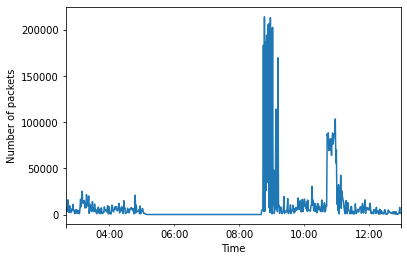

In [ ]:
f = plt.figure()
f.set_figwidth(6)
f.set_figheight(4)
ax=concat_df['total_fwd_packets'].plot(legend=False)
ax.set_xlabel("Time")
ax.set_ylabel("Number of packets")

Text(0, 0.5, 'Number of packets')

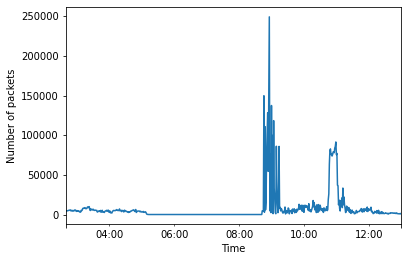

In [ ]:
f = plt.figure()
f.set_figwidth(6)
f.set_figheight(4)
ax=concat_df['predicted'].plot(legend=False)
ax.set_xlabel("Time")
ax.set_ylabel("Number of packets")

# Calculate error, x, y, lyapunov, A etc. & detect the attacks 

In [ ]:
concat_df['error']=concat_df['total_fwd_packets']-concat_df['predicted']

In [ ]:
concat_df['ips']=time_series_ips['source_ip']
concat_df['y']=concat_df['total_fwd_packets']

In [ ]:
concat_df['lyapunov']=np.log(np.abs(concat_df['error'] / concat_df['error'].iloc[0] ))
concat_df['alpha']=np.log(np.abs(concat_df['y'] / concat_df['y'].iloc[0] ))
concat_df['beta'] =np.log( concat_df['y'] / concat_df['y'].shift(1))
concat_df['n'] = concat_df['lyapunov'].apply(lambda x: 1 if x > 0 else -1 )
concat_df['sumn'] = concat_df['n'] + concat_df['n'].shift(1) + concat_df['n'].shift(2) + concat_df['n'].shift(3)


/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
concat_df['attack']=False
concat_df.loc[(concat_df['lyapunov'] > 0) & (concat_df['sumn'] > 3) & (concat_df['alpha'] > 1 ) & (concat_df['beta'] <= 1), 'attack'] = True 

In [ ]:
concat_df.tail(10)

,total_fwd_packets,predicted,error,ips,y,lyapunov,alpha,beta,n,sumn,attack
2017-07-05 12:50:00,3182,1497.375346,1684.624654,427,3182,-0.000516,0.043681,1.447862,-1,-4.0,False
2017-07-05 12:51:00,337,2055.344333,-1718.344333,91,337,0.019302,-2.201502,-2.245182,1,-2.0,False
2017-07-05 12:52:00,683,1124.153619,-441.153619,143,683,-1.340421,-1.495090,0.706412,-1,-2.0,False
2017-07-05 12:53:00,166,1343.239539,-1177.239539,37,166,-0.358887,-2.909597,-1.414507,-1,-2.0,False
2017-07-05 12:54:00,493,1026.454896,-533.454896,42,493,-1.150440,-1.821075,1.088521,-1,-2.0,False
2017-07-05 12:55:00,977,937.090824,39.909176,149,977,-3.743208,-1.137098,0.683977,-1,-4.0,False
2017-07-05 12:56:00,2625,859.539620,1765.460380,225,2625,0.046352,-0.148748,0.988350,1,-2.0,False
2017-07-05 12:57:00,7719,901.748126,6817.251874,1069,7719,1.397397,0.929856,1.078604,1,0.0,False
2017-07-05 12:58:00,1220,1353.126584,-133.126584,271,1220,-2.538514,-0.914978,-1.844834,-1,0.0,False
2017-07-05 12:59:00,1169,966.471562,202.528438,251,1169,-2.118934,-0.957681,-0.042702,-1,0.0,False


#Classification results


In [ ]:
time_series_label=rename_lables(df[['timestamp', 'label']])
time_series_label['timestamp'] = pd.to_datetime(time_series_label['timestamp'],dayfirst=True)
time_series_label = time_series_label.set_index('timestamp') 
time_series_label=time_series_label.groupby(pd.Grouper(freq='1min')).any()


In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import precision_recall_fscore_support,precision_score, recall_score, f1_score, classification_report


In [ ]:
time_series_label=time_series_label.iloc[100:]

In [ ]:
print(classification_report(time_series_label['label'], concat_df['attack'] ))

              precision    recall  f1-score   support

       False       0.90      0.97      0.93       536
        True       0.63      0.31      0.42        84

    accuracy                           0.88       620
   macro avg       0.77      0.64      0.68       620
weighted avg       0.86      0.88      0.86       620



In [ ]:
time_series_label['label'].values
concat_plot= pd.concat([time_series_label['label'], concat_df['attack']], axis=1)

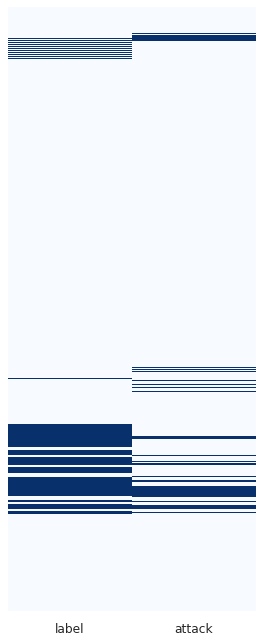

In [ ]:
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
figure(figsize=(4, 10), dpi=80)
sns.set_theme()
uniform_data = concat_plot
ax = sns.heatmap(uniform_data, yticklabels=False,cbar=False,cmap="Blues" )



In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
cf_matrix=confusion_matrix(time_series_label['label'], concat_df['attack'] )
cf_matrix

array([[521,  15],
       [ 58,  26]])

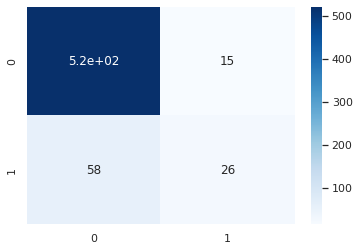

In [ ]:
import seaborn as sns
sns.heatmap(cf_matrix, annot=True, cmap='Blues')
